In [4]:
import sys
import os

env = "local" # "colab" or "local"

if env == "colab":
    %cd /content/sample_data/
    !git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git
    path = '/content/sample_data/scisciJP2024_tutorial'
if env == "local":
    path = '/Users/ti/Documents/code/tutorial/'

sys.path.append(path)
print(os.getcwd())

os.chdir(path)
sys.path

/Users/ti/Documents/code/tutorial/examples


['/Users/ti/Documents/code/tutorial/examples',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/ti/Library/Python/3.9/lib/python/site-packages',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site-packages',
 '/Users/ti/Documents/code/tutorial/']

In [5]:
%pip install pyalex 
%pip install japanize_matplotlib 
from pyalex import Works, Authors, Sources, Institutions, Concepts, Funders
import pyalex

import pandas as pd
import numpy as np
import math
import tqdm
import matplotlib.pyplot as plt
import japanize_matplotlib

import util

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pyalex.config.email = "zhmuler@gmail.com"

In [7]:
country = "US" # compare within a country. We take US as an example here.

# You can see the topic list here:
# https://docs.google.com/spreadsheets/d/1v-MAq64x4YjhO7RWcB-yrKV5D_2vOOsxl4u6GBKEXY8/edit?gid=983250122#gid=983250122
level = 2
subsets = [
    1110 #	Plant Science
]

In [8]:
pyalexObj = Institutions().filter(country_code=country).select(["id", "display_name", "cited_by_count"])
result = util.getAll(pyalexObj)
institutions_df = pd.DataFrame(result)
institutions_df.to_pickle("./supplementary/institutions_df.pickle")
institutions_df = pd.read_pickle("./supplementary/institutions_df.pickle")

Fetching 30654 objects. it may takes 2.55 to 7.66 minutes


155it [02:47,  1.08s/it]


In [172]:
# calculate a relative strength and investment in the field.
# relative institutional ranks are often insufficient as many of them 
# 組織内で成果が出ている分野と、インパクトを与えている分野の分析。

# Since the average number of citations varies by field, simply comparing the average or total citation counts
# will result in higher numbers for fields with a large annual publication volume, like computer science,
# and lower numbers for fields with fewer publications, like genetic engineering or mathematics
# Revealed Comperative Advantage、つまり分野の被引用数の相対的な割合が、世界平均での割合と比べてどの程度高いかの比で、分野同士を比較できるようになる。

citation_counts = pd.DataFrame()

for t in tqdm.tqdm(subsets, level=3): 
    # It usually takes about 10 years for the citation count to stabilize, so we focus on papers from 2010 to 2014.
    pyalexObj = Works().filter(
        from_publication_date="2010-01-01",to_publication_date="2014-12-31",\
        cited_by_count=">0",\
        authorships={"institutions":{"country_code":country}},\
        primary_topic={"id": "t"+str(t)}
    ).select([
        "id",
        "authorships",
        "cited_by_count"
    ])

    result = util.getAll(pyalexObj, verbous=False)
    for r in result:
        r["topic"] = t
        authorships = r["authorships"]
        authors = []
        for a in authorships:
            institution = a["institutions"]
            if len(institution)>0:
                institution_id = institution[0]["id"]
                if r.get("authors/institution/id", None) is None:
                    r["authors/institution/id"] = [institution_id]
                else:
                    r["authors/institution/id"].append(institution_id)
    
    citation_counts = pd.concat([citation_counts, pd.DataFrame(result)],axis=0)

citation_counts.shape[0] # the number of publications you obtained 

100%|██████████| 5/5 [00:44<00:00,  8.94s/it]


In [174]:
citation_count = citation_counts.explode(column=["authors/institution/id"])

institution_citation = citation_count.groupby(by="authors/institution/id").sum("cited_by_count").reset_index()
institution_citation = institution_citation.merge(institutions_df, left_on="authors/institution/id", right_on="id")
institution_citation["rca"] = institution_citation["cited_by_count_x"] / institution_citation["cited_by_count_y"] / (institution_citation["cited_by_count_x"].sum() / institution_citation["cited_by_count_y"].sum())
institution_citation = institution_citation.merge(citation_count["authors/institution/id"].value_counts(), left_on="authors/institution/id", right_index=True)

Text(0, 0.5, 'Impact')

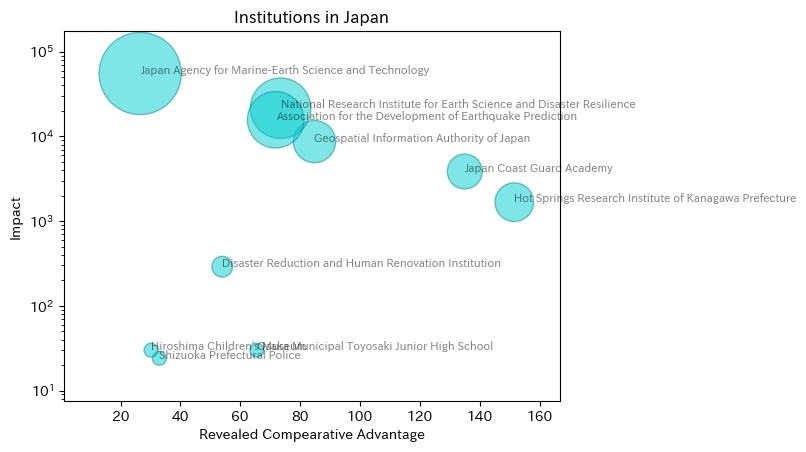

In [175]:
num_inst = 10
top_inst = institution_citation.sort_values(by="rca", ascending=False).head(num_inst)

x_range = (min(top_inst["rca"]), max(top_inst["rca"]))
y_range = (math.log10(min(top_inst["cited_by_count_x"])), math.log10(max(top_inst["cited_by_count_x"])))

dark_colors = ['olivedrab','orange' ,'darkcyan', 'orangered'] 
light_colors = [ 'yellowgreen', 'gold','darkturquoise','coral']
# colors = rca["domain_id_x"].apply(lambda x: light_colors[x-1])
# edgecolors = rca["domain_id_x"].apply(lambda x: dark_colors[x-1])

plt.scatter(top_inst["rca"], top_inst["cited_by_count_x"], s=top_inst["count"].apply(lambda x: math.sqrt(x)*100),c=light_colors[2],edgecolors=dark_colors[2], alpha=0.5)
labels = top_inst["display_name"]
for t, txt in enumerate(labels):
    plt.text(top_inst["rca"].iloc[t],top_inst["cited_by_count_x"].iloc[t] ,  txt, fontsize=8,alpha=0.5)

# plt.xscale("log")
plt.yscale("log")
plt.title(f"Institutions in Japan")
plt.xlim(1,x_range[1]*1.1)
plt.ylim(10**(y_range[0]-0.5),10**(y_range[1]+0.5))
plt.xlabel("Revealed Compearative Advantage")
plt.ylabel("Impact")